# Keypoint regression

Single keypoint regression consists of localizing a keypoint in an image. Here we'll be training on a head pose dataset, where every image has a person in it and the head of the person is annotated. Since keypoint datasets all have different formats, we have to do a bit more manual work to get the task dataset loaded. First we import everything we'll need:

In [ ]:
import CairoMakie; CairoMakie.activate!(type="png")
using DelimitedFiles: readdlm
using FastAI
using FastAI.FilePathsBase, FastAI.StaticArrays, FastAI.DLPipelines
import FastAI.DataAugmentation

## Creating a task data container

[`datasetpath`](#) downloads the files, but it's up to us to load them into a usable format. In the end, the task data container should contain tuples of an image and a keypoint each.

In [2]:
path = datasetpath("biwi_head_pose")

p"/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose"

In [3]:
files = FileDataset(path);
files[1:10]

10-element Vector{String}:
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01.obj"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/02"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/02.obj"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/03"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/03.obj"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/04"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/04.obj"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/05"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/05.obj"

First we create a [`FileDataset`](#) from the directory where the dataset has been downloaded to:

Loading a `FileDataset` simply treats every file as a single observation. However, that is not what we want here: for every observation we have one image and one annotation file that make up one observation and we want to ignore all other files, like the README. To achieve this, we'll create two data containers containing all the image paths and annotation paths respectively by filtering the container with all paths.

In [4]:
imagefiles = loadfolderdata(path, filterfn=isimagefile)
annotfiles = loadfolderdata(path, filterfn=p -> occursin("pose", pathname(p)))

15678-element view(::Vector{String}, [52, 54, 56, 58, 60, 62, 64, 66, 68, 70  …  31434, 31436, 31438, 31440, 31442, 31444, 31446, 31448, 31450, 31452]) with eltype String:
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00003_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00004_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00005_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00006_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00007_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00008_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00009_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00010_pose.txt"
 "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00011_p

In [5]:
(getobs(imagefiles, 1), getobs(annotfiles, 1))

("/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00003_rgb.jpg", "/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00003_pose.txt")

Next we need to map functions over each observation that load the data from the files. An image file can be loaded using the [`loadfile`](#) utility. The keypoints have a custom format, so we write a helper function to parse them from a text file. The details of how the format is loaded aren't important.

In [6]:
readcalibrationfile(p) = readdlm(string(p))[1:3, 1:3]

CAL = readcalibrationfile(joinpath(path, "01", "rgb.cal"))

function loadannotfile(annotpath, cal = CAL)
    ctr = readdlm(string(annotpath))[4,:]
    cx = ctr[1] * cal[1,1]/ctr[3] + cal[1,3]
    cy = ctr[2] * cal[2,2]/ctr[3] + cal[2,3]
    return [SVector(cy, cx) .+ 1]
end

loadannotfile (generic function with 2 methods)

Now we can use [`mapobs`](#) to lazily map the loading function over the container. Note that beside loading the image and keypoint, we also extract the subject ID from the path. We'll use this in a bit for splitting the dataset appropriately and we don't have access to the path information anymore once we have a container of loaded data. 

In [7]:
data = (
    mapobs(loadfile, imagefiles),
    mapobs(loadannotfile, annotfiles)
)
ids = map(p -> parse(Int, pathname(pathparent(p))), imagefiles)
obs = image, ks = getobs(data, 2000)

(ColorTypes.RGB{FixedPointNumbers.N0f8}[RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.004,0.004,0.004) … RGB{N0f8}(0.063,0.043,0.027) RGB{N0f8}(0.016,0.0,0.0); RGB{N0f8}(0.051,0.051,0.051) RGB{N0f8}(0.859,0.859,0.859) … RGB{N0f8}(0.522,0.502,0.486) RGB{N0f8}(0.059,0.039,0.024); … ; RGB{N0f8}(0.043,0.012,0.0) RGB{N0f8}(0.129,0.094,0.059) … RGB{N0f8}(0.463,0.447,0.435) RGB{N0f8}(0.078,0.059,0.043); RGB{N0f8}(0.027,0.0,0.0) RGB{N0f8}(0.055,0.02,0.0) … RGB{N0f8}(0.067,0.051,0.039) RGB{N0f8}(0.016,0.0,0.0)], SVector{2, Float64}[[237.24571342301059, 412.9481253320988]])

We can visualize an observation using [`DataAugmentation.showitems`](#) if we wrap the data in item types:

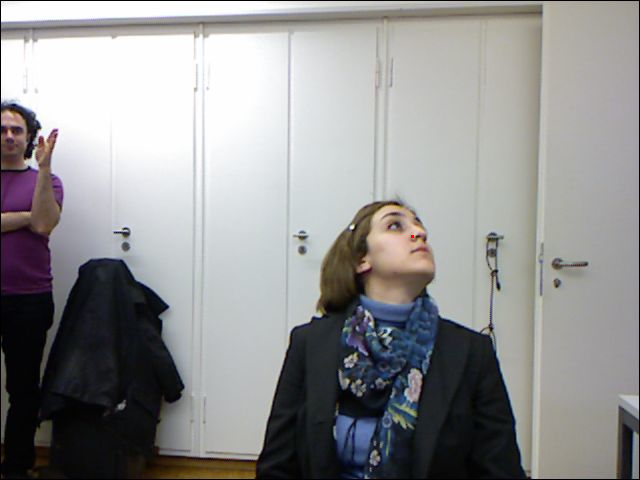

In [8]:
DataAugmentation.showitems((
    DataAugmentation.Image(image),
    DataAugmentation.Keypoints(ks, size(image)))
)

Before we can start using this data container for training, we need to split into a training and validation dataset. Since there are 13 different persons with many images each, randomly splitting the container does not make sense. The validation dataset would then contain many images that are very similar to those seen in training, and would hence say little about the generalization ability of a model. We instead use the first 12 subjects as a training dataset and validate on the last.

In [9]:
traindata = datasubset(data, (1:nobs(data))[ids .!= 13])
validdata = datasubset(data, (1:nobs(data))[ids .== 13])
nobs(traindata), nobs(validdata)

(15193, 485)

## The learning method

Next we need to define a [learning method](./learningmethods.md) that encodes and augments each image and keypoint in a form that we can train a model on. We need to create a `LearningMethod` struct for which we can define these transformations. Here we make use of [`ProjectiveTransforms`](#) for resizing, cropping and augmenting the image and keypoint and [`ImagePreprocessing`](#) to reshape and normalize the image. Finally, [`ScalePoints`](#) makes sure keypoints fall between -1 and 1.

In [62]:
sz = (128, 128)
method = BlockMethod(
    (Image{2}(), Keypoints{2}(1)),
    (
        ProjectiveTransforms(sz, buffered=true, augmentations=augs_projection(max_warp=0)),
        ImagePreprocessing(),
        KeypointPreprocessing(sz),
    )
)

BlockMethod(Image{2} -> Keypoints{2, 1})

We can check that each image is resized to `(224, 224)` and the keypoints are normalized:

In [63]:
im, k = getobs(traindata, 1)
x, y = encode(method, Training(), (im, k))
summary(x), y

("128×128×3 Array{Float32, 3}", Float32[0.06941247, -0.09283608])

Decoding the encoded targets should give back a point within the original image bounds:

In [64]:
DLPipelines.decodeŷ(method, Training(), y)

1-element Vector{SVector{2, Float32}}:
 [68.4424, 58.05849]

We should also visualize our data to make sure that after all the encoding it still makes sense and the keypoint is properly aligned with the head on the image. The visualizations are derived from the data blocks we used when defining our `BlockMethod`.

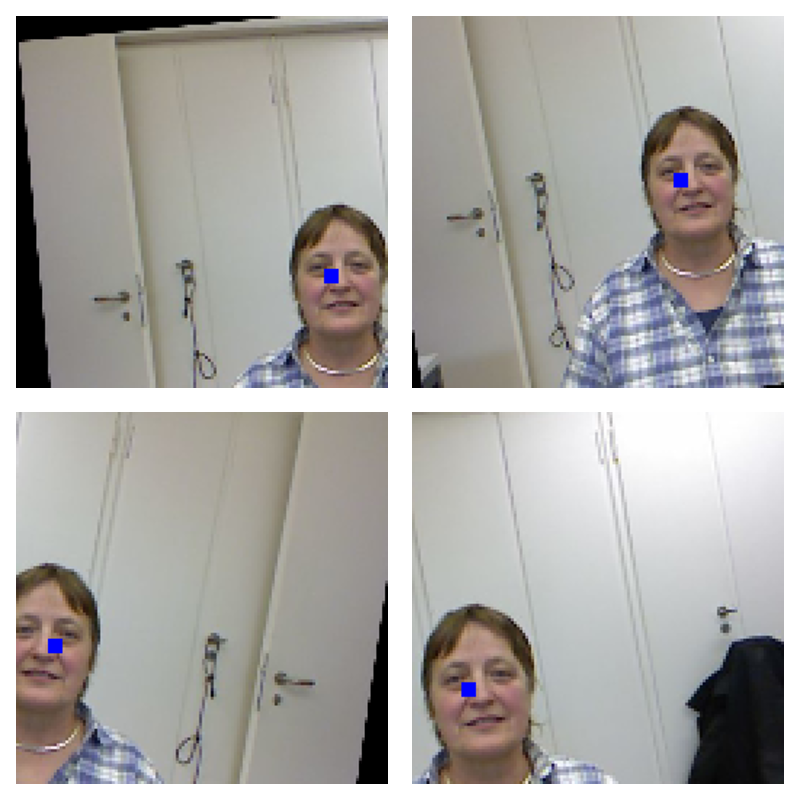

In [65]:
xs, ys = makebatch(method, traindata, 1:4)
plotbatch(method, xs, ys)

That is looking good! We can see that the keypoint is aligned with center of the head even after heavy augmentation. Now it is finally time to train a model.

## Training

We will finetune a pretrained model provided by Metalhead.jl (make sure to follow the [setup instructions](setup.md) for the right version). Since the pretrained models are trained on classification tasks, we need to remove the last few layers and replace them with layers that regress the keypoint. [`methodmodel`](#) knows how to do this by looking at the data blocks used and calling [`blockmodel`](#)`(KepointTensor{2, Float32}((1,)), KeypointTensor{2, Float32}((1,)), backbone)`.

The implementation, for reference, looks like this:
```julia
function blockmodel(inblock::ImageTensor{N}, outblock::KeypointTensor{N}, backbone) where N
    outsz = Flux.outputsize(backbone, (ntuple(_ -> 256, N)..., inblock.nchannels, 1))
    outch = outsz[end-1]
    head = Models.visionhead(outch, prod(outblock.sz)*N, p = 0.)
    return Chain(backbone, head)
end
```

In [66]:
using Metalhead

backbone = Metalhead.ResNet50(pretrain=true).layers[1][1:end-1]
model = methodmodel(method, backbone);

Next we create a pair of training and validation data loaders. They take care of batching and loading the data in parallel in the background.

In [67]:
traindl, validdl = FastAI.methoddataloaders(traindata, validdata, method, 16)

(eachobsparallel(batchviewcollated() with 950 batches of size 16), eachobsparallel(batchviewcollated() with 16 batches of size 32))

With the addition of an optimizer and a loss function, we can now create a [`Learner`](#) and start training. Just like [`methomodel`](#), [`methodlossfn`](#) selects the appropriate loss function for a `BlockMethod`s blocks. Here both the encoded target block and model output block are `block = KeypointTensor{2, Float32}((1,))`, so `blocklossfn(block, block)` is called which returns Mean Squared Error as a suitable loss function.

In [68]:
learner = Learner(
    model,
    (traindl, validdl),
    Flux.ADAM(),
    methodlossfn(method),
    ToGPU())

Learner()

In [69]:
finetune!(learner, 6)

Epoch 1 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:12


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   1.0 │ 0.36222 │
└───────────────┴───────┴─────────┘


Epoch 1 ValidationPhase(): 100%|████████████████████████| Time: 0:00:01


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   1.0 │ 0.05413 │
└─────────────────┴───────┴─────────┘


Epoch 2 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:12


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   2.0 │ 0.06943 │
└───────────────┴───────┴─────────┘


Epoch 2 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   2.0 │ 0.00892 │
└─────────────────┴───────┴─────────┘


Epoch 3 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:14


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   3.0 │ 0.06124 │
└───────────────┴───────┴─────────┘


Epoch 3 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   3.0 │ 0.00837 │
└─────────────────┴───────┴─────────┘


Epoch 4 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:13


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   4.0 │ 0.05194 │
└───────────────┴───────┴─────────┘


Epoch 4 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   4.0 │ 0.02347 │
└─────────────────┴───────┴─────────┘


Epoch 5 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:15


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   5.0 │ 0.03956 │
└───────────────┴───────┴─────────┘


Epoch 5 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   5.0 │ 0.01177 │
└─────────────────┴───────┴─────────┘


Epoch 6 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:15


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   6.0 │ 0.02941 │
└───────────────┴───────┴─────────┘


Epoch 6 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬────────┐
│           Phase │ Epoch │   Loss │
├─────────────────┼───────┼────────┤
│ ValidationPhase │   6.0 │ 0.0084 │
└─────────────────┴───────┴────────┘


Epoch 7 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:12


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   7.0 │ 0.02542 │
└───────────────┴───────┴─────────┘


Epoch 7 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   7.0 │ 0.00394 │
└─────────────────┴───────┴─────────┘


Learner()

The loss is going down which is a good sign, but visualizing the predictions against the ground truth will give us a better idea of how well the model performs. We'll use [`plotpredictions`](#) to compare batches of encoded targets and model outputs. For this we can run the model on a batch from the validation dataset and see how it performs.

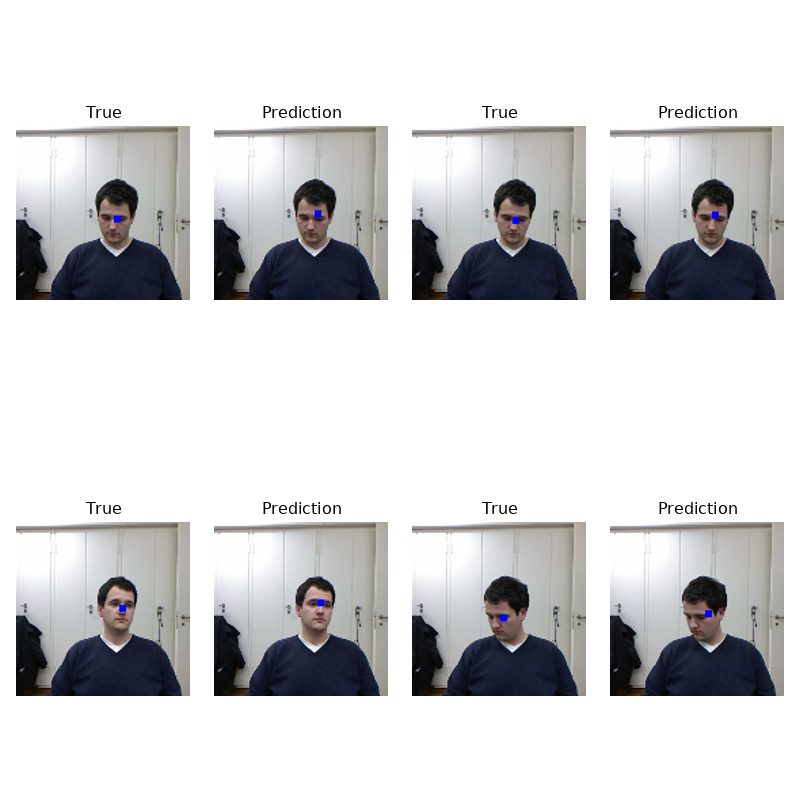

In [71]:
xs, ys = makebatch(method, validdata, rand(1:485, 4), context = Validation())
ŷs = learner.model(gpu(xs)) |> cpu
FastAI.plotpredictions(method, xs, ŷs, ys)

We can also see that the trained model generalizes well to the heavy augmentation employed during training. The augmentation also explains why the training loss is so much higher than the validation loss.

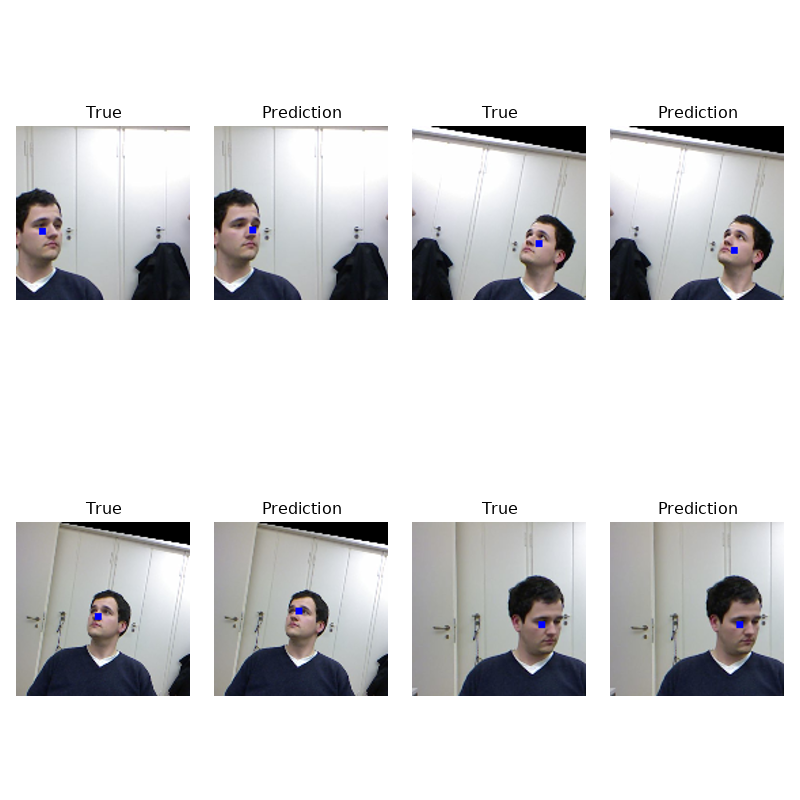

In [73]:
xs, ys = makebatch(method, validdata, rand(1:485, 4), context = Training())
ŷs = learner.model(gpu(xs)) |> cpu
FastAI.plotpredictions(method, xs, ŷs, ys)